In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from matplotlib import pyplot as plt
import numpy as np
# import torch
# from torchvision.utils import save_image
# import torch.nn as nn

import os

In [3]:
os.makedirs("HerbaceousVegetation", exist_ok=True)

In [4]:
print(tf.version.VERSION)

2.7.1


In [5]:
#!unzip '/home/ubuntu/efs/data/archive(1).zip'

In [6]:
new_data_dir = "/home/ubuntu/efs/data/archive/RBG/train/HerbaceousVegetation"

In [7]:
train_images = tf.keras.utils.image_dataset_from_directory(
    new_data_dir, label_mode=None, image_size=(64, 64), batch_size=16
)


Found 2400 files belonging to 1 classes.


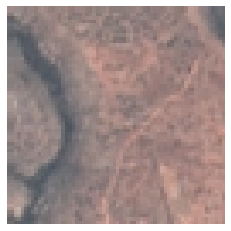

In [8]:
image_batch = next(iter(train_images))
random_index = np.random.choice(image_batch.shape[0])
random_image = image_batch[random_index].numpy().astype("int32")
plt.axis("off")
plt.imshow(random_image)
plt.show()

In [9]:
# Normalize the images to [-1, 1] which is the range of the tanh activation
train_images = train_images.map(lambda x: (x - 127.5) / 127.5)

In [10]:
# latent dimension of the random noise
LATENT_DIM = 128
# weight initializer for G per DCGAN paper 
WEIGHT_INIT = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02) 
# number of channels, 1 for gray scale and 3 for color images
CHANNELS = 3

In [11]:
def build_generator():
    # create a Keras Sequential model 
    model = Sequential(name="generator")

    # prepare for reshape: FC => BN => RN layers, note: input shape defined in the 1st Dense layer  
    model.add(layers.Dense(8 * 8 * 512, input_dim=LATENT_DIM))
    # model.add(layers.BatchNormalization()) 
    model.add(layers.ReLU())
    # layers.LeakyReLU(alpha=0.2),

    # 1D => 3D: reshape the output of the previous layer 
    model.add(layers.Reshape((8, 8, 512)))

    # upsample to 16x16: apply a transposed CONV => BN => RELU
    model.add(layers.Conv2DTranspose(256, (4, 4), 
                                     strides=(2, 2),
                                     padding="same", 
                                     use_bias=False, 
                                     kernel_initializer=WEIGHT_INIT))
    model.add(layers.BatchNormalization()) 
    model.add((layers.ReLU()))

    # upsample to 32x32: apply a transposed CONV => BN => RELU
    model.add(layers.Conv2DTranspose(128, (4, 4), 
                                     strides=(2, 2),
                                     padding="same", 
                                     use_bias=False, 
                                     kernel_initializer=WEIGHT_INIT))
    model.add(layers.BatchNormalization()) 
    model.add((layers.ReLU()))

    # upsample to 64x64: apply a transposed CONV => BN => RELU
    model.add(layers.Conv2DTranspose(4, (4, 4), 
                                     strides=(2, 2),
                                     padding="same", 
                                     use_bias=False, 
                                     kernel_initializer=WEIGHT_INIT))
    model.add(layers.BatchNormalization()) 
    model.add((layers.ReLU()))

    # final layer: Conv2D with tanh activation
    model.add(layers.Conv2D(CHANNELS, (4, 4), padding="same", activation="tanh"))

    # return the generator model
    return model



In [12]:
# build the generator model
generator = build_generator()

In [13]:
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32768)             4227072   
                                                                 
 re_lu (ReLU)                (None, 32768)             0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 512)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 256)      2097152   
 nspose)                                                         
                                                                 
 batch_normalization (BatchN  (None, 16, 16, 256)      1024      
 ormalization)                                                   
                                                                 
 re_lu_1 (ReLU)              (None, 16, 16, 256)       0 

In [14]:
# UPDATE for WGAN-GP: no more weight clipping
# class WeightClip(tf.keras.constraints.Constraint):
#     def __init__(self, clip_value):
#         self.clip_value = clip_value
    
#     def __call__(self, weights):
#         return tf.clip_by_value(weights, -self.clip_value, self.clip_value)
    
#     def get_config(self):
#         return {'clip_value': self.clip_value}

In [15]:
def build_critic(height, width, depth, alpha=0.2):
    # Weight clipping to [-1, 1] to enfoce 1-Lipschitz constraint
    # constraint = WeightClip(0.01) # UPDATE for WGAN-GP: remove weight clipping

    # create a Keras Sequential model
    model = Sequential(name="critic")
    input_shape = (height, width, depth)

    # 1. first set of CONV => BN => leaky ReLU layers
    model.add(layers.Conv2D(64, (4, 4), 
                            padding="same", 
                            strides=(2, 2), 
                            # kernel_constraint = constraint, # UPDATE for WGAN-GP: remove weight clipping
                            input_shape=input_shape))
    # model.add(layers.BatchNormalization()) # UPDATE for WGAN-GP: remove batchnorm
    model.add(layers.LeakyReLU(alpha=alpha))

    # 2. second set of CONV => BN => leacy ReLU layers
    model.add(layers.Conv2D(128, (4, 4), 
                            padding="same", 
                            strides=(2, 2))) 
                            # kernel_constraint = constraint,)) # UPDATE for WGAN-GP: remove weight clipping
    # model.add(layers.BatchNormalization()) # UPDATE for WGAN-GP: remove batchnorm
    model.add(layers.LeakyReLU(alpha=alpha))

    # 3. third set of CONV => BN => leacy ReLU layers
    model.add(layers.Conv2D(128, (4, 4), 
                            padding="same", 
                            strides=(2, 2))) 
                            # kernel_constraint = constraint,)) # UPDATE for WGAN-GP: remove weight clipping
    # model.add(layers.BatchNormalization()) # UPDATE for WGAN-GP: remove batchnorm
    model.add(layers.LeakyReLU(alpha=alpha))

    # flatten and apply dropout
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.3)) 

    # linear activation in the last layer 
    # Note: Keras `Dense` layer by default is already a `linear` activation
    model.add(layers.Dense(1, activation="linear"))

    # return the critic model
    return model

In [16]:
# build the critic model
critic = build_critic(64, 64, 3)

In [17]:
critic.summary()

Model: "critic"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        3136      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 128)         262272    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 flatten (Flatten)           (None, 8192)              0    

In [18]:
# def build_discriminator(height, width, depth, alpha=0.2):
#     # create a Keras Sequential model
#     model = Sequential(name='discriminator')
#     input_shape = (height, width, depth)

#     # 1. first set of CONV => BN => leaky ReLU layers
#     model.add(layers.Conv2D(64, (4, 4), padding="same", strides=(2, 2),
#         input_shape=input_shape))
#     model.add(layers.BatchNormalization())
#     model.add(layers.LeakyReLU(alpha=alpha))

#     # 2. second set of CONV => BN => leacy ReLU layers
#     model.add(layers.Conv2D(128, (4, 4), padding="same", strides=(2, 2)))
#     model.add(layers.BatchNormalization())
#     model.add(layers.LeakyReLU(alpha=alpha))

#     # 3. third set of CONV => BN => leacy ReLU layers
#     model.add(layers.Conv2D(128, (4, 4), padding="same", strides=(2, 2)))
#     model.add(layers.BatchNormalization())
#     model.add(layers.LeakyReLU(alpha=alpha))

#     # flatten and apply dropout
#     model.add(layers.Flatten())
#     model.add(layers.Dropout(0.3))

#     # sigmoid in the last layer outputting a single value for binary classification
#     model.add(layers.Dense(1, activation="sigmoid"))

#     # return the discriminator model
#     return model



In [19]:
# # build the discriminator model
# discriminator = build_discriminator(64, 64, 3)

In [20]:
# discriminator.summary()

In [21]:
class WGAN_GP(keras.Model):
    def __init__(self, 
                 critic, 
                 generator, 
                 latent_dim, 
                 critic_extra_steps, 
                 gp_weight=10.0): # UPDATE for WGAN-GP: gradient penalty weight
        super().__init__()
        self.critic = critic
        self.generator = generator
        self.latent_dim = latent_dim
        self.c_extra_steps = critic_extra_steps
        self.gp_weight = gp_weight # WGAN-GP
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")


    def compile(self, d_optimizer, g_optimizer, d_loss_fn, g_loss_fn):
        super(WGAN_GP, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_fn = d_loss_fn
        self.g_loss_fn = g_loss_fn

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    # UPDATE for WGAN-GP: use gradient penalty instead of weight clipping
    def gradient_penalty(self, batch_size, real_images, fake_images):
        """ Calculates the gradient penalty.

        Gradient penalty is calculated on an interpolated image
        and added to the discriminator loss.
        """
        
        alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
        diff = fake_images - real_images
        # 1. Create the interpolated image
        interpolated = real_images + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            # 2. Get the Critic's output for the interpolated image
            pred = self.critic(interpolated, training=True)

        # 3. Calculate the gradients w.r.t to the interpolated image
        grads = gp_tape.gradient(pred, [interpolated])[0]
        # 4. Calculate the norm of the gradients.
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        # 5. Calculate gradient penalty
        gradient_penalty = tf.reduce_mean((norm - 1.0) ** 2)
        return gradient_penalty

    def train_step(self, real_images):

        batch_size = tf.shape(real_images)[0]
        noise = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Train the critic more often than the generator by 5 times (self.c_extra_steps) 
        for i in range(self.c_extra_steps):
            # Step 1. Train the critic with both real images and fake images
            with tf.GradientTape() as tape:
                pred_real = self.critic(real_images, training=True)
                fake_images = self.generator(noise, training=True) 
                pred_fake = self.critic(fake_images, training=True)
                # UPDATE for WGAN-GP: Calculate the gradient penalty
                gp = self.gradient_penalty(batch_size, real_images, fake_images)
                # UPDATE for WGAN-GP: Add gradient penalty to the original critic loss 
                d_loss = self.d_loss_fn(pred_real, pred_fake) + gp * self.gp_weight 
            # Compute critic gradients
            grads = tape.gradient(d_loss, self.critic.trainable_variables)
            # Update critic weights
            self.d_optimizer.apply_gradients(zip(grads, self.critic.trainable_variables))

        # Step 2. Train the generator (do not update weights of the critic)
        misleading_labels = tf.ones((batch_size, 1)) # G wants D to think the fake images are real (label as 1)

        with tf.GradientTape() as tape:
            fake_images = self.generator(noise, training=True)
            pred_fake = self.critic(fake_images, training=True)
            g_loss = self.g_loss_fn(pred_fake)
        # Compute generator gradients
        grads = tape.gradient(g_loss, self.generator.trainable_variables)
        # Update generator wieghts
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_variables))

        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)

        return {"d_loss": self.d_loss_metric.result(), "g_loss": self.g_loss_metric.result()}

In [22]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=256, latent_dim=100):
        self.num_img = num_img
        self.latent_dim = latent_dim
        #self.right_path = 'Forest' + str(p)

        # Create random noise seed for visualization during traing
        self.seed = tf.random.normal([256, latent_dim])

    def on_epoch_end(self, epoch, logs=None):
        generated_images = self.model.generator(self.seed)
        generated_images = (generated_images * 127.5) + 127.5
        generated_images= generated_images.numpy()
        

        if epoch ==299:
            #fig = plt.figure(figsize=(64, 64))
            px = 1/plt.rcParams['figure.dpi']  # pixel in inches
            fig = plt.figure(figsize=(64*px, 64*px))
            #plt.subplots(figsize=(600*px, 200*px))
            for i in range(self.num_img):
                #plt.subplot(4, 4, i+1)
                img = keras.utils.array_to_img(generated_images[i]) 
                plt.imshow(img)
                plt.axis('off')
                plt.savefig('HerbaceousVegetation/HerbaceousVegetation{:03d}.png'.format(i))
        else:
            pass


In [23]:
wgan_gp = WGAN_GP(critic=critic, 
              generator=generator, 
              latent_dim=LATENT_DIM,
              critic_extra_steps=5)

In [24]:
# Wasserstein loss for the critic
def d_wasserstein_loss(pred_real, pred_fake):
    real_loss = tf.reduce_mean(pred_real)
    fake_loss = tf.reduce_mean(pred_fake)
    return fake_loss - real_loss

# Wasserstein loss for the generator
def g_wasserstein_loss(pred_fake):
    return -tf.reduce_mean(pred_fake)

In [25]:
LR = 0.0002 # WGAN-GP paper recommends lr of 0.0002
d_optimizer = keras.optimizers.Adam(learning_rate=LR, beta_1=0.5, beta_2=0.9) # UPDATE for WGAN-GP: use Adam instead of RMSProp
g_optimizer = keras.optimizers.Adam(learning_rate=LR, beta_1=0.5, beta_2=0.9) # UPDATE for WGAN-GP: 

In [26]:
wgan_gp.compile(
    d_optimizer=d_optimizer,
    g_optimizer=g_optimizer,  
    d_loss_fn = d_wasserstein_loss,
    g_loss_fn = g_wasserstein_loss
)

In [27]:
# D_LR = 0.0001 # UPDATED: discriminator learning rate
# G_LR = 0.0003 # UPDATED: generator learning rate

# dcgan.compile(
#     d_optimizer=keras.optimizers.Adam(learning_rate=D_LR, beta_1 = 0.5),
#     g_optimizer=keras.optimizers.Adam(learning_rate=G_LR, beta_1 = 0.5),  
#     loss_fn=keras.losses.BinaryCrossentropy(),
# )

In [ ]:
NUM_EPOCHS = 300 # number of epochs
wgan_gp.fit(train_images, epochs=NUM_EPOCHS, callbacks=[GANMonitor(num_img=256, latent_dim=LATENT_DIM)])


Epoch 1/300
150/150 [==============================] - 12s 39ms/step - d_loss: -42.1138 - g_loss: 53.7832
Epoch 2/300
150/150 [==============================] - 6s 38ms/step - d_loss: -13.7716 - g_loss: 54.0455
Epoch 3/300
150/150 [==============================] - 6s 37ms/step - d_loss: -12.4052 - g_loss: 48.5514
Epoch 4/300
150/150 [==============================] - 6s 37ms/step - d_loss: -12.4011 - g_loss: 60.0093
Epoch 5/300
150/150 [==============================] - 6s 37ms/step - d_loss: -12.2081 - g_loss: 69.0852
Epoch 6/300
150/150 [==============================] - 5s 37ms/step - d_loss: -11.0941 - g_loss: 69.2824
Epoch 7/300
150/150 [==============================] - 5s 37ms/step - d_loss: -10.0534 - g_loss: 76.6870
Epoch 8/300
150/150 [==============================] - 6s 37ms/step - d_loss: -10.0909 - g_loss: 102.2469
Epoch 9/300
150/150 [==============================] - 5s 36ms/step - d_loss: -9.9844 - g_loss: 88.3910
Epoch 10/300
150/150 [==============================] 